In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


import pamtra2
import refractiveIndex
import singleScattering
import pyPamtraRadarSimulator

try:
    %matplotlib inline
except:
    pass

Define variables, not very realistic ones!

In [9]:
edr = 1e-4
wind_uv = 10
height = 1000
temperature = 300
pia = 0
temp = 300
press = 100000
wind_w = 0


frequency = 3e9
c = 299792458 
wavelength = c/frequency


diameter_spec = np.logspace(-4,-2.5,80)
diameter_width = np.gradient(diameter_spec)

rainRate = 1
number_concentration = pamtra2.hydrometeors.sizeDistribution.exponentialMarshallPalmer(
                diameter_spec, rainRate)


diameter_spec = np.array([0.001])
diameter_width = np.array([1e-6])
number_concentration = pamtra2.hydrometeors.sizeDistribution.monoDisperse(diameter_width,10)
refInd = refractiveIndex.water.n(temperature,frequency)
refInd

back_crosssec = singleScattering.Rayleigh.RayleighScatt(
    diameter=diameter_spec,
    frequency = frequency,
    refractive_index=refInd
).Cbck

rho_particle = 1000.
mass = pamtra2.hydrometeors.mass.waterSphere(diameter_spec)
area = pamtra2.hydrometeors.crossSectionArea.sphere(diameter_spec)
rho_particle= np.ones_like(diameter_spec)*rho_particle

backSpec = back_crosssec * number_concentration * diameter_width
    
    
dryAirDensity = 1.23
kinematicViscosity = 1.343e-5
velSpec = pamtra2.hydrometeors.fallVelocity.khvorostyanov01_drops(
    diameter_spec, dryAirDensity, kinematicViscosity)

In [10]:
K2=0.92
Ze_back = 1.e18*(1/(K2*np.pi**5))*backSpec*(wavelength)**4

    
10*np.log10(Ze_back)

array([10.02850403])

/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=10000000.0, top=10000000.0
  'bottom=%s, top=%s') % (bottom, top))


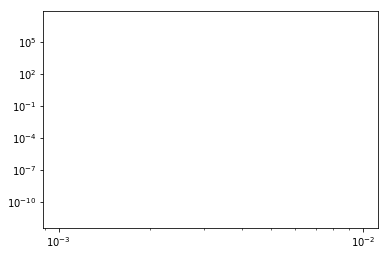

In [11]:
# plt.figure()
plt.loglog(diameter_spec,number_concentration)
# plt.figure()
plt.loglog(diameter_spec,back_crosssec)
plt.loglog(diameter_spec,backSpec)

Estimate the broadening of the spectrum (Function is now integrated in main radar simulator routine)

In [12]:

specBroadening = pyPamtraRadarSimulator.calcSpectralBroadening(
    np.array([edr]),
    np.array([wind_uv]),
    np.array([height]),
    np.array([wavelength]),
    radarBeamwidthDeg=0.2,
    radarIntegrationTime=60,
    kolmogorov=0.5,
    verbosity=0
)
                                                              
specBroadening


array([0.18421374])

In [13]:

# pyPamtraRadarSimulator.createRadarSpectrum(
#     diameterSpec=np.array([[1]*20]),
#     backSpec=np.array([[2]*20]),
#     massSpec=np.array([[3]*20]),
#     rhoSpec=np.array([[4]*20]),
#     areaSpec=np.array([[5]*20]),
#     temperature=np.array([6]),
#     pressure=np.array([7]),
#     verticalWind=np.array([8]),
#     wavelength=np.array([9]),
#     fallVelocityRelation='10',
#     radarMaxV=11,
#     radarMinV=12,
#     radarAliasingNyquistInterv=13,
#     radarNFFT=14,
#     radarAirmotion=True,
#     radarAirmotionModel="16",
#     radarAirmotionVmin=17,
#     radarAirmotionVmax=18,
#     radarAirmotionLinearSteps=19,
#     radarAirmotionStepVmin=20,
#     radarK2=21,
#     verbosity=10,
# )

In [14]:

idealizedSpec = pyPamtraRadarSimulator.createRadarSpectrum(
    diameterSpec=np.array([diameter_spec]),
    backSpec=np.array([backSpec]),
    massSpec=np.array([mass]),
    rhoSpec=np.array([rho_particle]),
    areaSpec=np.array([area]),
    fallVelSpec=np.array([velSpec]),
    verticalWind=np.array([wind_w]),
    wavelength=np.array([wavelength]),
#     radarMinV=-7.885,
#     radarAliasingNyquistInterv=1,
#     radarNFFT=256,
#     radarAirmotion=True,
#     radarAirmotionModel="constant",
#     radarAirmotionVmin=0,
#     radarAirmotionVmax=0,
#     radarAirmotionLinearSteps=30,
#     radarAirmotionStepVmin=0.5,
#     radarK2=0.93,
#     verbosity=10,
)

plt.plot(idealizedSpec.flatten())


RuntimeError: Error in Fortran routine radar_spectrum

In [ ]:


radarSpectrum = pyPamtraRadarSimulator.simulateRadarSpectrum(
    height=np.array([height]),
    eddyDissipationRate=np.array([edr]),
    horizontalWind=np.array([wind_uv]),
    mergedParticleSpec=idealizedSpec,
    pathIntegratedAtenuattion=np.array([pia]),
    wavelength=np.array([wavelength]),
#     radarMaxV=7.885,
#     radarMinV=-7.885,
#     radarAliasingNyquistInterv=1,
#     radarNFFT=256,
#     radarPNoise1000=-30,
#     radarK2=0.93,
#     radarNAve=150,
#     radarBeamwidthDeg=0.2,
#     radarIntegrationTime=60,
#     kolmogorov=0.5,
    seed=10,
#     verbosity=0,
)
vspec = np.linspace(-7.885,7.885,256,endpoint=False)
plt.plot(vspec,10*np.log10(radarSpectrum.flatten()))

Use combined method for convenience

In [10]:

radarSpectrum2 = pyPamtraRadarSimulator.radarSimulator(
    diameterSpec=np.array([[diameter_spec]]),
    backSpec=np.array([[backSpec]]),
    massSpec=np.array([[mass]]),
    rhoSpec=np.array([[rho_particle]]),
    areaSpec=np.array([[area]]),
    pathIntegratedAtenuattion=np.array([pia]),
    height=np.array([height]),
    temperature=np.array([temp]),
    pressure=np.array([press]),
    verticalWind=np.array([wind_w]),
    horizontalWind=np.array([wind_uv]),
    eddyDissipationRate=np.array([edr]),
    wavelength=np.array([wavelength]),
    fallVelocityRelation='heymsfield10_particles',
#     radarMaxV=7.885,
#     radarMinV=-7.885,
#     radarAliasingNyquistInterv=1,
#     radarNFFT=256,
#     radarAirmotion=True,
#     radarAirmotionModel="constant",
#     radarAirmotionVmin=0,
#     radarAirmotionVmax=0,
#     radarAirmotionLinearSteps=30,
#     radarAirmotionStepVmin=0.5,
#     radarPNoise1000=-30,
#     radarK2=0.93,
#     radarNAve=150,
#     radarBeamwidthDeg=0.2,
#     radarIntegrationTime=60,
    seed=10,
#     verbosity=0
)


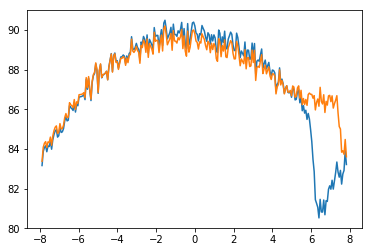

In [11]:
plt.plot(vspec,10*np.log10(radarSpectrum.flatten()))
plt.plot(vspec,10*np.log10(radarSpectrum2.flatten()))

In [11]:
import pyPamtraRadarMoments

spectrumOut, moments, slope, edge, quality, noiseMean = pyPamtraRadarMoments.calc_radarMoments(radarSpectrum2)

/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


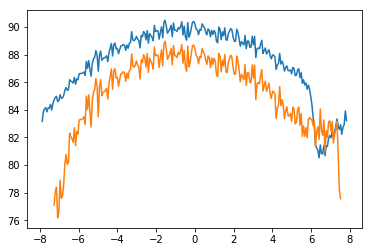

In [12]:
plt.plot(vspec,10*np.log10(radarSpectrum.flatten()))
plt.plot(vspec,10*np.log10(spectrumOut.flatten()))

In [13]:
10*np.log10(moments[0,0,:]), moments[0,1,:]



/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([109.78185078,          nan,          nan]),
 array([-1.18666016e-01, -9.99900000e+03, -9.99900000e+03]))